#CREATING AVERAGE HEATMAPS

✅ Processed and cropped: /content/drive/MyDrive/DATA/MEC_SALT_2_4/hr10/petri0_0020_03.Apr.2025_03.57.17.jpg


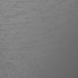

✅ Processed and cropped: /content/drive/MyDrive/DATA/MEC_SALT_2_4/hr10/petri1_0020_03.Apr.2025_03.57.58.jpg


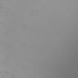

✅ Processed and cropped: /content/drive/MyDrive/DATA/MEC_SALT_2_4/hr10/petri2_0020_03.Apr.2025_03.58.38.jpg


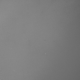

✅ Processed and cropped: /content/drive/MyDrive/DATA/MEC_SALT_2_4/hr10/petri3_0020_03.Apr.2025_03.59.18.jpg


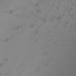

In [6]:
import cv2
import numpy as np
import imutils
from google.colab.patches import cv2_imshow
import time

# Input image paths
image_paths = ["/content/drive/MyDrive/DATA/MEC_SALT_2_4/hr10/petri0_0020_03.Apr.2025_03.57.17.jpg",
               "/content/drive/MyDrive/DATA/MEC_SALT_2_4/hr10/petri1_0020_03.Apr.2025_03.57.58.jpg",
               "/content/drive/MyDrive/DATA/MEC_SALT_2_4/hr10/petri2_0020_03.Apr.2025_03.58.38.jpg",
               "/content/drive/MyDrive/DATA/MEC_SALT_2_4/hr10/petri3_0020_03.Apr.2025_03.59.18.jpg"
]

square_images = []  # To hold the final centered and cropped lawn images

for image_path in image_paths:
    image = cv2.imread(image_path)
    if image is None:
        print(f"❌ Error loading image: {image_path}")
        continue

    # Resize
    scale_percent = 25
    new_width = int(image.shape[1] * scale_percent / 100)
    new_height = int(image.shape[0] * scale_percent / 100)
    resized_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)

    # Convert to grayscale and apply CLAHE
    grey_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_image = clahe.apply(grey_image)

    # Detect circles
    circles = cv2.HoughCircles(
        clahe_image, cv2.HOUGH_GRADIENT, dp=1.2, minDist=100,
        param1=80, param2=180, minRadius=40, maxRadius=300
    )

    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        x, y, r = circles[0]
        r = int(max(r - 15, 0))

        # --- Crop to center region of dish ---
        top_left_x = int(max(x - 2*r, 0))
        top_left_y = int(max(y - 2*r, 0))
        bottom_right_x = int(min(x + 2*r, grey_image.shape[1]))
        bottom_right_y = int(min(y + 2*r, grey_image.shape[0]))
        centred_image = grey_image[top_left_y:bottom_right_y, top_left_x:bottom_right_x]
        # cv2_imshow(centred_image)

        # --- Rotate image for alignment ---  # Adjust angle individually is needed
        filename = image_path.split("/")[-1]  # just the filename
        rotation_dict = {
              "petri0_0020_04.Feb.2025_08.54.09.jpg": 15,
              "petri1_0020_04.Feb.2025_08.54.16.jpg": 0,
              "petri2_0020_04.Feb.2025_08.54.21.jpg": 15,
              "petri3_0020_04.Feb.2025_08.54.26.jpg": 15,
          }
        rotation_angle = rotation_dict.get(filename, 0)
        Rotated_image = imutils.rotate(centred_image, angle=rotation_angle)

        # --- Final square crop around the rotated center ---
        new_h, new_w = Rotated_image.shape[:2]
        new_center_x = new_w // 2
        new_center_y = new_h // 2
        crop_size = int(0.65 * r)

        top_left_x = max(new_center_x - crop_size, 0)
        top_left_y = max(new_center_y - crop_size, 0)
        bottom_right_x = min(new_center_x + crop_size, new_w)
        bottom_right_y = min(new_center_y + crop_size, new_h)

        square_image = Rotated_image[top_left_y:bottom_right_y, top_left_x:bottom_right_x]
        square_images.append(square_image)

        print(f"✅ Processed and cropped: {image_path}")
        cv2_imshow(square_image)
        time.sleep(1)  # Optional pause to inspect

    else:
        print(f"❗ No circles found in: {image_path}")



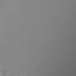

In [7]:
min_h = min(img.shape[0] for img in square_images)
min_w = min(img.shape[1] for img in square_images)

resized_squares = [
    cv2.resize(img, (min_w, min_h), interpolation=cv2.INTER_AREA)
    for img in square_images
]

cleaned_images = []
laplacian_threshold = 50  # Can be tuned

for img in resized_squares:
    img = img.astype(np.float32)

    # Apply Laplacian filter on float64 image
    laplacian = cv2.Laplacian(img.astype(np.float64), cv2.CV_64F)
    lap_var = cv2.GaussianBlur(np.square(laplacian), (3, 3), 0)

    mask = lap_var < laplacian_threshold
    cleaned = np.where(mask, img, np.nan)
    cleaned_images.append(cleaned)

# Stack and average only unmasked pixels
stacked = np.stack(cleaned_images, axis=0)
average_image = np.nanmean(stacked, axis=0)

# Convert to displayable format
average_image_uint8 = np.nan_to_num(average_image, nan=np.nanmean(average_image))
average_image_uint8 = np.clip(average_image_uint8, 0, 255).astype(np.uint8)


cv2_imshow(average_image_uint8)

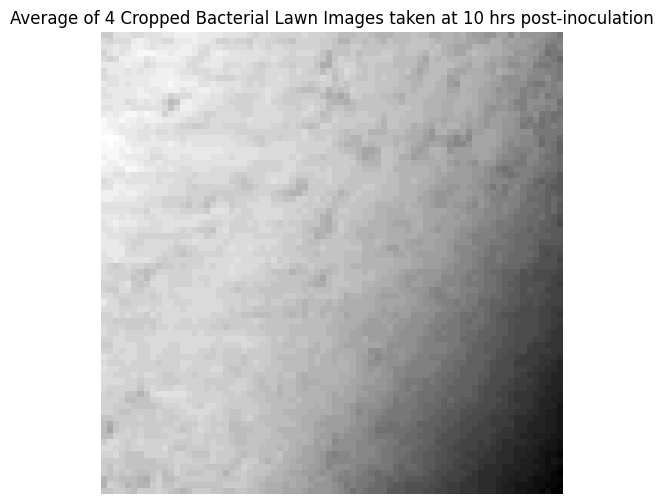

In [8]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Step 1: Make sure all square images are the same size
min_h = min([img.shape[0] for img in square_images])
min_w = min([img.shape[1] for img in square_images])

# Resize all to the smallest common shape
resized_squares = [cv2.resize(img, (min_w, min_h), interpolation=cv2.INTER_AREA) for img in square_images]

# Step 2: Convert to float32 for averaging
float_squares = [img.astype(np.float32) for img in resized_squares]

# Step 3: Stack and compute average
stacked = np.stack(float_squares, axis=0)  # Shape: (4, H, W)
average_image = np.mean(stacked, axis=0)   # Shape: (H, W)

# Step 4: Normalize and convert back to uint8 for viewing
average_image_uint8 = np.clip(average_image, 0, 255).astype(np.uint8)

# Step 5: Show the averaged grayscale image
plt.figure(figsize=(6, 6))
plt.imshow(average_image_uint8, cmap='gray')
plt.title('Average of 4 Cropped Bacterial Lawn Images taken at 10 hrs post-inoculation')
plt.axis('off')
plt.show()


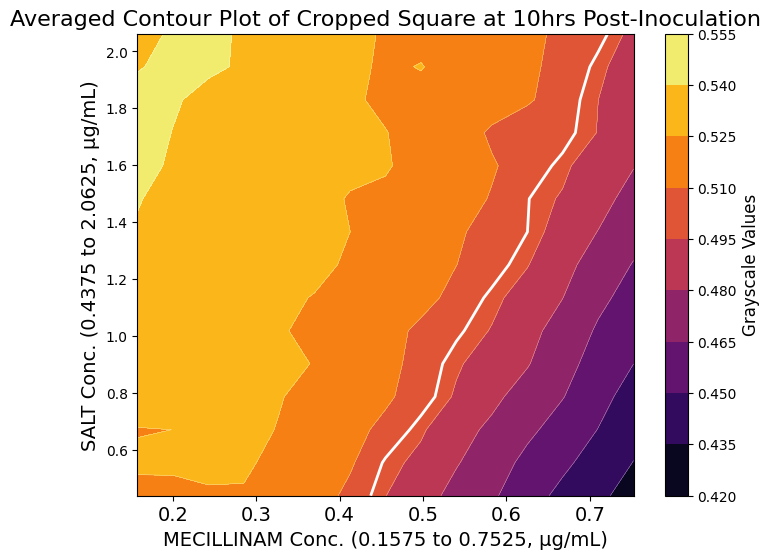

In [10]:
#Generating a heat map
#import necessary plotting library
import matplotlib.pyplot as plt
#Divide square image of centre of petri into a grid, define intesnity for each section
grid_size = 15  # Number of grid cells (both x and y)
step_x = average_image_uint8.shape[1] // grid_size # floor division used to prevent decimals: needs to fit neatly.
step_y = average_image_uint8.shape[0] // grid_size
intensity_map = np.zeros((grid_size, grid_size))

for i in range(grid_size):
    for j in range(grid_size):
        cell = average_image_uint8[i * step_y:(i + 1) * step_y, j * step_x:(j + 1) * step_x]
        intensity_map[i, j] = np.mean(cell)
#normalising and plotting heatmap
intensity_map = intensity_map / 255.0
intensity_map = np.flipud(intensity_map)
fig, ax = plt.subplots(figsize=(8, 6))
x_vals = np.linspace(0.1575, 0.7525, grid_size)
y_vals = np.linspace(0.4375, 2.0625, grid_size)
c1 = ax.contourf(x_vals, y_vals, intensity_map, levels=10, cmap='inferno')
c2 = ax.contour(x_vals, y_vals, intensity_map, levels=10, colors='white', linewidths=0.2)
ax.contour(x_vals, y_vals, intensity_map, levels=[0.50], colors='white', linewidths=2)

cbar = fig.colorbar(c1, ax=ax)
cbar.set_label('Grayscale Values', fontsize=12)
ax.set_xlim(0.1575, 0.7525)
ax.set_ylim(0.4375, 2.0625)
ax.set_aspect('auto')
ax.set_title('Averaged Contour Plot of Cropped Square at 10hrs Post-Inoculation', fontsize=16)
ax.set_xlabel(r'MECILLINAM Conc. (0.1575 to 0.7525, µg/mL)', fontsize=14)
ax.set_ylabel(r'SALT Conc. (0.4375 to 2.0625, µg/mL)', fontsize=14)
ax.tick_params(axis='x', which='major', labelsize=14)
#ax.set_yticklabels([]) #remove y labels if doing a single gradient.
plt.show()